# Correlational Neural Networks with Tensorflow

![alt text](https://deeplearnschool.files.wordpress.com/2017/05/cornet.png)

# Import Modules

Import all the necessary modules for training and testing the CorrNet

In [56]:
%pylab inline

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.contrib.keras as keras

# Our modules
import corrnet.data.mnist_views
import corrnet.layers
import corrnet.loss

Populating the interactive namespace from numpy and matplotlib


# Fetch and split MNIST data

left_mnist contains the left halves of images and right_mnist contains the right halves
Usage:
- left_mnist.train.images: Left images for training
- left_mnist.validation.images: Left images for validation
- left_mnist.test.images: Left images for testing

Example of a MNIST image left and right halves:
![alt text](https://deeplearnschool.files.wordpress.com/2017/05/d2.png?w=340&h=245)

In [57]:
left_mnist = corrnet.data.mnist_views.left_view_dataset()
right_mnist = corrnet.data.mnist_views.right_view_dataset()

# CorrNet and training configuration

In [58]:
n_inputs = 28*14
hdim1, hdim2, hdim = 500, 300, 50
learning_rate = 0.001
n_epochs = 40
batch_size = 100
lamda = 0.02

tf.reset_default_graph()

# Build CorrNet with tensorflow

We will build a NN with 3 encoding layers (for both modalities), 1 common layer and 1 decoding layer (for both modalities).

- The encoding layers will build a "pyramid" with decreasing hidden units (l1: 500 -> l2: 300 -> l3: 50)
- The common layer adds the output of l3 for left and right input

In [59]:
X1 = tf.placeholder(tf.float32, shape=(None,n_inputs), name='X1')
X2 = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X2')
keep_prob = tf.placeholder(tf.float32)

with tf.name_scope('dnn'):
    h1_X1_l = corrnet.layers.dense_layer(X1, hdim1, name='h1_X1', activation=corrnet.activations.leaky_relu)
    h1_o = h1_X1_l.apply(X1)
    h1_X2_l = corrnet.layers.dense_layer(X2, hdim1, name='h1_X2', activation=corrnet.activations.leaky_relu)
    h2_o = h1_X2_l.apply(X2)

    h2_X1_l = corrnet.layers.dense_layer(h1_o, hdim2, name='h2_X1', activation=corrnet.activations.leaky_relu)
    h1_o = h2_X1_l.apply(h1_o)
    h2_X2_l = corrnet.layers.dense_layer(h2_o, hdim2, name='h2_X2', activation=corrnet.activations.leaky_relu)
    h2_o = h2_X2_l.apply(h2_o)

    h1_l = corrnet.layers.dense_layer(h1_o, hdim, name='h1', activation=corrnet.activations.leaky_relu)
    h1_o = h1_l(h1_o)
    h2_l = corrnet.layers.dense_layer(h2_o, hdim, name='h2', activation=corrnet.activations.leaky_relu)
    h2_o = h2_l(h2_o)
    h_l = keras.layers.Add()
    h_o = h_l([h1_o, h2_o])
    
    r1_X1_l = corrnet.layers.dense_layer(h_o, n_inputs, name='r1_X1', activation=corrnet.activations.leaky_relu)
    reconstruct_X1 = r1_X1_l.apply(h_o)

    r1_X2_l = corrnet.layers.dense_layer(h_o, n_inputs, name='r1_X2', activation=corrnet.activations.leaky_relu)
    reconstruct_X2 = r1_X2_l.apply(h_o)    


# Define loss, optimizer and evaluation metric

The loss function is defined as:
![alt text](https://deeplearnschool.files.wordpress.com/2017/05/eq31.png?w=640)

- We use all terms and set lambda=0.02
- Adam optimizer with learning_rate=0.001 ensures fast and stable convergence

In [60]:
with tf.name_scope('loss'):
    loss = corrnet.loss.calculate_loss(
        [h1_X1_l, h2_X1_l, h1_l],
        [h1_X2_l, h2_X2_l, h2_l],
        [r1_X1_l], [r1_X2_l],
        h_l, [X1, X2],
        ['l1', 'l2', 'l3', 'l4'], lamda=lamda)

with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss)

with tf.name_scope('eval'):
    reconstruction_accuracy = loss

# Train model

Use minibatch training with batch_size = 100 for 40 epochs.

In [61]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(left_mnist.train.num_examples // batch_size):
            X_batch1, _ = left_mnist.train.next_batch(batch_size, shuffle=False)
            X_batch2, _ = right_mnist.train.next_batch(batch_size, shuffle=False)
            sess.run(train_op, feed_dict={X1: X_batch1, X2: X_batch2})
        acc_train = reconstruction_accuracy.eval(feed_dict={X1: X_batch1, X2: X_batch2})
        X_val_batch1 = left_mnist.validation.images
        X_val_batch2 = right_mnist.validation.images
        acc_validation = reconstruction_accuracy.eval(feed_dict={X1: X_val_batch1, X2: X_val_batch2})
        print('Epoch: {}\tTrain accuracy: {}\tValidation accuracy: {}'.format(epoch, acc_train, acc_validation))

    X_test1 = left_mnist.test.images
    X_test2 = right_mnist.test.images
    rec_left, rec_right = sess.run([reconstruct_X1, reconstruct_X2], feed_dict={X1: X_test1, X2: X_test2})
    rec_left_left, rec_left_right = sess.run([reconstruct_X1, reconstruct_X2], feed_dict={X1: X_test1, X2: np.zeros_like(X_test2)})
    rec_right_left, rec_right_right = sess.run([reconstruct_X1, reconstruct_X2], feed_dict={X1: np.zeros_like(X_test1), X2: X_test2})

    acc_test = reconstruction_accuracy.eval(feed_dict={X1: X_test1, X2: X_test2})
    print('Test accuracy: {}'.format(acc_test))
    save_path = saver.save(sess, './my_model_final_multi.ckpt')

Epoch: 0	Train accuracy: 0.135617911816	Validation accuracy: 7.59412050247
Epoch: 1	Train accuracy: 0.105549052358	Validation accuracy: 6.4984254837
Epoch: 2	Train accuracy: 0.0904521644115	Validation accuracy: 5.69390630722
Epoch: 3	Train accuracy: 0.0826511234045	Validation accuracy: 5.26948547363
Epoch: 4	Train accuracy: 0.074488542974	Validation accuracy: 4.91267156601
Epoch: 5	Train accuracy: 0.0699452906847	Validation accuracy: 4.60951948166
Epoch: 6	Train accuracy: 0.0665562897921	Validation accuracy: 4.41534280777
Epoch: 7	Train accuracy: 0.0635370761156	Validation accuracy: 4.23102045059
Epoch: 8	Train accuracy: 0.0608576983213	Validation accuracy: 4.13588523865
Epoch: 9	Train accuracy: 0.0599887259305	Validation accuracy: 4.07832813263
Epoch: 10	Train accuracy: 0.0573939830065	Validation accuracy: 3.94658398628
Epoch: 11	Train accuracy: 0.0561895817518	Validation accuracy: 3.91816234589
Epoch: 12	Train accuracy: 0.0548528395593	Validation accuracy: 3.91364789009
Epoch: 13	Tra

# Visual Evaluation

## Original example image

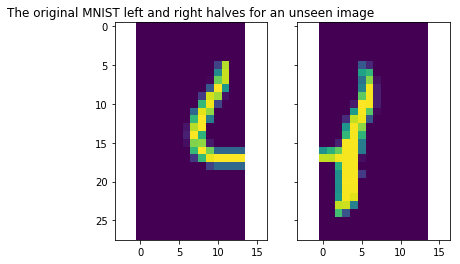

In [63]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(np.reshape(left_mnist.test.images[4], (28,14)))
ax1.set_title('The original MNIST left and right halves for an unseen image')
ax2.imshow(np.reshape(right_mnist.test.images[4], (28,14)))

## Reconstruction when both and right images are provided to the NN

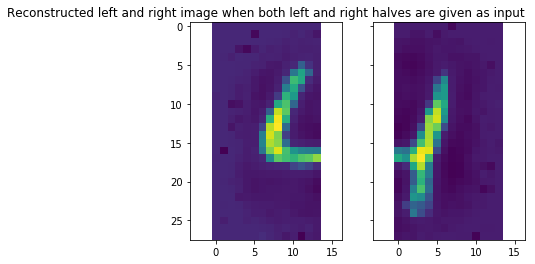

In [65]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(np.reshape(rec_left[4], (28,14)))
ax1.set_title('Reconstructed left and right image when both left and right halves are given as input')
ax2.imshow(np.reshape(rec_right[4], (28,14)))

## Self and cross reconstruction when only left image is provided

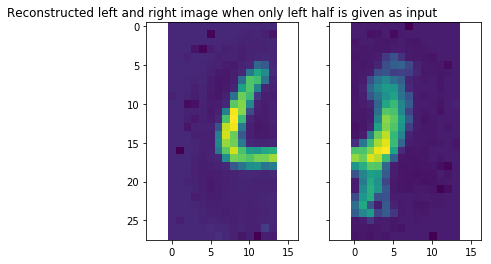

In [66]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(np.reshape(rec_left_left[4], (28,14)))
ax1.set_title('Reconstructed left and right image when only left half is given as input')
ax2.imshow(np.reshape(rec_left_right[4], (28,14)))

## Self and cross reconstruction when only right image is provided

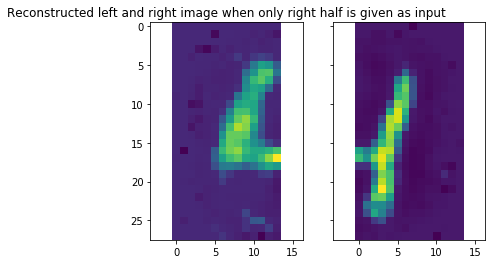

In [67]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(np.reshape(rec_right_left[4], (28,14)))
ax1.set_title('Reconstructed left and right image when only right half is given as input')
ax2.imshow(np.reshape(rec_right_right[4], (28,14)))